<a href="https://colab.research.google.com/github/Antonio96128/Intent_detection/blob/master/Attention_model_for_intent_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is this notebook about?

In this notebook we will discuss one of the classic applications of NLP, intent detection. As a side note, this problem is pretty much the same as sentiment classification, so you could start from here in case you need to solve that problem. All you have to remember is that both problems are of the type "many to one", in the context of RNN's.

So, how do we tackle this problem? Well, there are many approaches we could follow, from old fashion algorithms to deep learning. For the purposes of this notebook we will try to solve this problem using one of the most powerful ideas available for natural language tasks, an attention mechanism. You can learn from a more advanced topic here: https://arxiv.org/abs/1706.03762, but we  will not dicuss, for now, transformers. Additionally, the code we will type can be easily modified for other NLP tasks, like machine translation.  

Before going into the deep learning algorithm we have to preprocess our data, because as we will see we cannot use it in its current state. By the way, the dataset can be found here: https://www.kaggle.com/hassanamin/atis-airlinetravelinformationsystem.

# Importing libraries

In [1]:
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
import time
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch import optim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_df  =  pd.read_csv('atis_intents_train.csv', header=None)
test_df   =  pd.read_csv('atis_intents_test.csv', header=None)
train_df.sample(10)

,0,1
1624,atis_flight,show me all flights from pittsburgh to oaklan...
664,atis_flight,list flights from boston to san francisco tha...
3268,atis_flight,show me all flights from charlotte to philade...
3218,atis_flight,show me flights from san francisco to pittsbu...
3749,atis_flight,does continental airlines fly from denver to ...
2790,atis_flight,show me all flights from boston to denver whi...
2972,atis_flight,show me one way flights from tampa to st. lou...
3117,atis_ground_service,ground transportation in dallas and boston
1325,atis_flight,what northwest airline flights leave denver b...
2289,atis_flight,what is the last flight from atlanta to boston


We can see that the queries are all about airline services, but the approach we will follow works fine for other domains. Also, it is important to notice that ALTHOUGH the text is pretty clean we will still write functions that can handle more complicated text inputs; for example, special characters or uncommon words. To help our neural network to better understand language, we will use a vector representation for words, or word embedding. In this notebook we will use a pretrained word embedding which can be found here: https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation. Notice that you could train your own word representation BUT it is not only VERY time consumming, it also requieres a lot of data.  

Let's preprocess our data. One important thing to notice is that the dataset is IMBALANCED, so we will have to deal with this issue eventually.

In [3]:
train_df.columns = ['Class', 'Text']
test_df.columns  = ['Class', 'Text']

In [4]:
train_df.Class.value_counts()

atis_flight            3666
atis_airfare            423
atis_ground_service     255
atis_airline            157
atis_abbreviation       147
atis_aircraft            81
atis_flight_time         54
atis_quantity            51
Name: Class, dtype: int64

In [5]:
num_classes = train_df.Class.nunique()
num_classes

8

In [6]:
y      = train_df.Class
X      = train_df.Text.to_numpy()

y_TEST = test_df.Class
X_TEST = test_df.Text.to_numpy()


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2) 

In [7]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_val   = encoder.transform(y_val)
y_TEST  = encoder.transform(y_TEST)

In [8]:
pd.Series(y_train).value_counts()

4    2929
2     342
6     204
3     135
0     113
1      64
5      41
7      39
dtype: int64

In [9]:
X_train

array([' what flights are available from denver to san francisco',
       ' what airlines flies out of atlanta',
       ' list all american airlines from milwaukee to phoenix on saturday',
       ..., ' train to newark',
       ' show me airlines between boston and san francisco',
       " i'd like to arrange a flight from pittsburgh to atlanta"],
      dtype=object)

Now, the hardest part of preprocessing. First, we load the embedding and create dictionaries to map from words to indexes and vectors, and viceversa.

In [10]:
def read_glove_vecs(glove_file):
    '''Create dictionaries using the word embedding'''
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


In [11]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

Let's see some examples.

In [12]:
word_to_index['intelligence']

191006

In [13]:
index_to_word[191006]

'intelligence'

In [14]:
word_to_vec_map['intelligence']

array([ 0.8782   , -0.45171  ,  0.96737  ,  0.040347 ,  0.76235  ,
       -0.63825  ,  0.18944  , -0.26633  ,  0.58874  , -0.93608  ,
       -0.065201 ,  0.5123   , -0.69111  ,  0.52807  , -0.71195  ,
       -0.2834   , -0.34591  ,  0.014351 ,  0.11763  ,  0.59407  ,
        0.20703  ,  0.69087  ,  1.0855   , -0.83158  , -0.35967  ,
       -2.3939   , -0.88375  , -0.417    , -0.36717  ,  0.58897  ,
        2.4132   , -0.74281  , -0.3619   , -1.9934   ,  0.093133 ,
        0.86592  , -0.75185  ,  0.19073  , -0.54284  , -0.0084839,
        0.57554  ,  0.4475   ,  0.48515  ,  0.054866 ,  0.35842  ,
       -0.51698  , -0.026014 ,  1.9907   , -0.11378  ,  0.30127  ])

As we can see, the vector representation is of dimension 50.

One great thing of these representations is that they REALLY encode the meaning of words! Well, they do a pretty good work at it. For example, we can work with analogies from a linear algebra perspective. If we were to find the completion for the analogy: Paris is to France as Rome is to _____ , we would need to find the vector that satisfies the relation: V_paris - V_france = V_rome - ???

Just a subtle a thing, rather than the square difference, it is more common to use cosine similarity, so your results are independent of the norm of the vectors. The intuition is that orthogonal vectors are as different as they can be, while parallel vectors are similar.

Let's return to our problem.

In [15]:
def special_char(word):
    '''This function deals with special characters that are sticked to words. For example, #AI is transformed into # AI'''
    
    chars = [ "!", "?", "@", "#", "$", "%", "^", "&", "*", '(', ')', '-', '_', '+', '=', '{', '}','[', ']', '/', ';', ',', '|', '<', '>', '\\', '~', '`', ':', '"', ".", "'" ]
    
    for char in chars:
        
        if char in word:
            
            word = word.lower().replace(char, ' ' + char + ' ').split()
            word = ' '.join(word)


    return word

In [16]:
print(special_char("#Deep Learning is the best!!!"))

# deep learning is the best ! ! !


In [17]:
def get_indexes(sentences, max_len):  
    '''Get the indexes for each word in a sentence'''
    
    indexes = np.zeros(( sentences.shape[0], max_len))

    for i in range(sentences.shape[0]):
        
        j = 0
            
        for word in sentences[i].split():
            
            if j < max_len:
                            
                words = special_char(word).split()
                    
                for word in words:
                        
                    if j < max_len:
    
                        try:
                                                   
                            indexes[i,j] = word_to_index[word.lower()]
                            j+=1
                        
        
                        except KeyError:
                            continue
                    else:
                        break
            else:
                break
        
    return indexes


In [18]:
X_train[0]

' what flights are available from denver to san francisco'

In [19]:
first_word  =  X_train[0].split()[0]
second_word =  X_train[0].split()[1]
third_word  =  X_train[0].split()[2]

In [20]:
get_indexes(X_train[:1], max_len = 20)

array([[386307., 150037.,  58997.,  63822., 154323., 121051., 360915.,
        317286., 153003.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.]])

Just to be explicit, recall that:

In [21]:
print(word_to_index[first_word], ',', word_to_index[second_word], ',', word_to_index[third_word])

386307 , 150037 , 58997


Great, now, let's do it for all the sets, and also let's create an embedding matrix because Pytorch needs the mapping in that form.

In [22]:
def create_embedding(word_to_index, word_to_vec_map):
    '''Create the embedding matrix'''
    num_embeddings =  len(word_to_vec_map) + 1
    embedding_dim  =  len(word_to_vec_map['1'])
    
    embedding_matrix = np.zeros((num_embeddings, embedding_dim))

    for word, index in word_to_index.items():
        
        embedding_matrix[index, :] = word_to_vec_map[word]


    return embedding_matrix



In [23]:
embedding_matrix =  create_embedding(word_to_index, word_to_vec_map)

In [24]:
X_train_text = X_train.copy()
X_val_text   = X_val.copy()
X_TEST_text  = X_TEST.copy()

In [25]:
X_train = get_indexes(X_train, max_len = 20)
X_val   = get_indexes(X_val  , max_len = 20)
X_TEST  = get_indexes(X_TEST , max_len = 20)

In [26]:
X_train[0,:]

array([386307., 150037.,  58997.,  63822., 154323., 121051., 360915.,
       317286., 153003.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.])

Let's make everything Pytorch friendly.

In [27]:
embedding_matrix  =   torch.tensor(embedding_matrix)



X_train   =  torch.from_numpy(X_train.astype(np.float32))
X_val     =  torch.from_numpy(X_val.astype(np.float32))
X_TEST    =  torch.from_numpy(X_TEST.astype(np.float32))


y_train   =  torch.from_numpy(y_train)
y_train   =  y_train.type(torch.LongTensor)

y_val     =  torch.from_numpy(y_val)
y_val     =  y_val.type(torch.LongTensor)

y_TEST    =  torch.from_numpy(y_TEST)
y_TEST    =  y_TEST.type(torch.LongTensor)


X_train   =  torch.transpose(X_train, 0,1)
X_train   =  X_train.type(torch.LongTensor)

X_val     =  torch.transpose(X_val, 0,1)
X_val     =  X_val.type(torch.LongTensor)


X_TEST    =  torch.transpose(X_TEST, 0,1)
X_TEST    =  X_TEST.type(torch.LongTensor)


In [28]:
X_train[:,0]

tensor([386307, 150037,  58997,  63822, 154323, 121051, 360915, 317286, 153003,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0])

Below, we have the attention model. Notice that the first part is a standard bidirectional RNN, in particular we use a GRU. After getting the outputs from the RNN we perform the attention mechanism. It consists of combining the outputs from the recurrent units in such a way that we can write a linear combination of them, where the coefficients are learned as any other parameter of the model, via gradient descent. Mathematically, we have:

$$context = \sum_{t = 1}^{T_x} \alpha^{<t>} V^{<t>} = \alpha * V,$$

where $\alpha$ is the vector of coefficients (which sum to one) and $V$ is the "vector" that contains the outputs from all the recurrent units. Intuitively, we notice that the larger $\alpha_t$ is, the more relevance $V_{t}$ has in the classification.


Notice that we set the weights in the loss function in a manner that takes into account the imbalance of the dataset.

In [29]:
class Attention_Model(nn.Module):
    
    
    def __init__(self, embedding_matrix, input_size, hidden_size, num_layers, dropout_prob, num_classes):
        super(Attention_Model, self).__init__()
        
        self.hidden_size =  hidden_size

        self.embedding   =  nn.Embedding.from_pretrained(embedding_matrix)        
        self.GRU         =  nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout_prob, bidirectional = True )
        self.linear_1    =  nn.Linear(in_features = 2*hidden_size , out_features = hidden_size )
        self.linear_2    =  nn.Linear(in_features =   hidden_size , out_features = 1 )


        self.linear_3   =  nn.Linear(in_features = 2*hidden_size    , out_features = hidden_size      )
        self.linear_4   =  nn.Linear(in_features =   hidden_size    , out_features = hidden_size // 2 )
        self.linear_5   =  nn.Linear(in_features = hidden_size // 2 , out_features = hidden_size // 4 )
        self.linear_6   =  nn.Linear(in_features = hidden_size // 4 , out_features = num_classes      )



        self.costs      =  []
        self.weights_1  =  torch.tensor([4.39, 7.55, 1.41, 3.66, 0.165, 10.98, 2.37, 10.98])   ###  We can set the weights in a proper way to deal with IMBALANCE. 
                                                                                               ###  Here we used n_samples/(n_classes * n_samples_in_each_class)


        self.criterion  =  nn.CrossEntropyLoss(weight = self.weights_1)
        self.softmax_attention = nn.Softmax(dim = 1)
        self.softmax_predict   = nn.Softmax(dim = 1)

        
        

    def forward(self, X):                
        
        X                  =  self.embedding(X)                           ### Embedding 
        
        X                  =  X.type(torch.float32)
        
        output, hn         =  self.GRU(X)                                 ### GRU
        
        output_attention   =  torch.transpose(output, 0, 1)
        


        output_attention   =  self.linear_1(output_attention)

        output_attention   =  self.linear_2(output_attention)


    

        output_attention   =  torch.squeeze(output_attention)
 
        alphas             =  self.softmax_attention(output_attention)     ### Get the alphas
        
        alphas             =  torch.unsqueeze(alphas, 1)

        output             =  torch.transpose(output, 0, 1)
        
        context            =  torch.bmm(alphas, output)                    ### Get the context vector
        
        context            =  torch.squeeze(context)
        



        final_output       =  self.linear_3(context)

        final_output       =  self.linear_4(final_output)

        final_output       =  self.linear_5(final_output)




        final_output       =  self.linear_6(final_output)

    
        return final_output, alphas

    
    
    def one_step_train(self, X_train, Y_train, optimizer):
        
        optimizer.zero_grad()
        
        output, _ =  self.forward(X_train)
        
        loss      =  self.criterion(output, Y_train) 
        
        self.costs.append(loss.item())
        
        loss.backward()
    
        optimizer.step()        
        



    def Train(self, num_epochs, X_train, Y_train, optimizer):
        
        
        for i in range(num_epochs):
            
            self.one_step_train(X_train,Y_train, optimizer)
            
            if i % 500 == 0:
                print("Epoch =", i)
            
                        
        plt.plot(self.costs)
        
        
        
        
    def predict(self, X):
        
        
        predictions, alphas  = self.forward(X)
        
        predictions          = self.softmax_predict(predictions)
        
        predictions          = torch.argmax(predictions, axis = 1)
        
        return predictions.detach(), alphas.detach()



Now, we train our model.

In [30]:
def Model_Run(X_train, y_train, X_val, y_val, num_classes, hidden_size, num_layers, dropout_prob, num_epochs, reg_lambda, is_GPU_ON):

    


    print('Hidden size = ', hidden_size ) 
    print("Num layers  = ", num_layers  )
    print("Dropout p   = ", dropout_prob)
    print("Num Epochs  = ", num_epochs  )
    print("L2 reg par  = ", reg_lambda  )



    
    input_size        =  len(word_to_vec_map['1'])  # embedding dimension = 50

    


    # Define the model and the optimizer

    model      =    Attention_Model(embedding_matrix = embedding_matrix, input_size = input_size, hidden_size = hidden_size,
                              num_layers = num_layers, dropout_prob = dropout_prob, num_classes = num_classes)
    

    optimizer  =    optim.Adam(model.parameters(), weight_decay = reg_lambda)







    # Decide whether you use or not the GPU. Highly recommended!

    device = None

    if is_GPU_ON:
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(device)
        model.to(device)
        
        
        X_train  =  X_train.to(device)
        y_train  =  y_train.to(device)
        
        X_val    =  X_val.to(device)
        y_val    =  y_val.to(device)





#####  TRAINING       TRAINING      TRAINING     TRAINING       TRAINING      TRAINING     TRAINING     #####


    initial_time = time.time()
    
    model.Train(num_epochs = num_epochs, X_train = X_train, Y_train = y_train, optimizer = optimizer)
    
    final_time = time.time()
    print("Training time  =", final_time - initial_time)





#####  PREDICTING      PREDICTING       PREDICTING       PREDICTING      PREDICTING       PREDICTING     #####

    
    
    train_predictions, train_alphas  =  model.predict(X_train)
    val_predictions,   val_alphas    =  model.predict(X_val  )
    
                     
    return train_predictions.cpu().numpy(), train_alphas.cpu().numpy(), y_train.cpu().numpy(), val_predictions.cpu().numpy(), val_alphas.cpu().numpy(), y_val.cpu().numpy(), model

Hidden size =  10
Num layers  =  1
Dropout p   =  0
Num Epochs  =  1501
L2 reg par  =  0
cuda:0
Epoch = 0
Epoch = 500
Epoch = 1000
Epoch = 1500
Training time  = 15.6593337059021


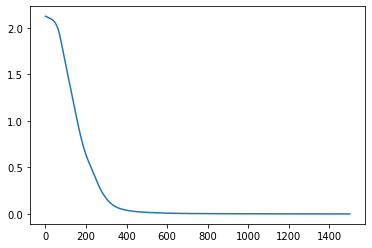

In [31]:
train_predictions, train_alphas, y_train, val_predictions, val_alphas, y_val, model   =    Model_Run( X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, num_classes = num_classes, 
                                                                                                    hidden_size = 10, num_layers = 1, dropout_prob = 0, num_epochs = 1501, reg_lambda = 0, is_GPU_ON = True)
            

To compare the predictions, let's see the confusion matrix and the classification report for the training set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00        64
           2       1.00      1.00      1.00       342
           3       1.00      1.00      1.00       135
           4       1.00      1.00      1.00      2929
           5       1.00      1.00      1.00        41
           6       1.00      1.00      1.00       204
           7       1.00      1.00      1.00        39

    accuracy                           1.00      3867
   macro avg       1.00      1.00      1.00      3867
weighted avg       1.00      1.00      1.00      3867




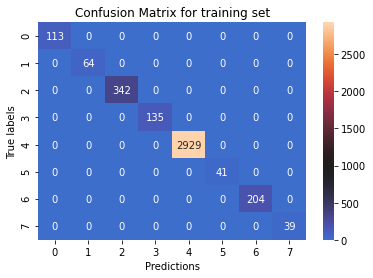

In [32]:
CR = classification_report(y_train, train_predictions)

print(CR)

CM = confusion_matrix(y_train, train_predictions)

plt.figure("Confusion Matrix for training set")
plt.title("Confusion Matrix for training set")
sns.heatmap(CM, annot = True, fmt="d", center = 1000)
plt.xlabel("Predictions")
plt.ylabel("True labels")
print()

Excelent! At least our model is learning something. Now let's see whether we can generalize.

Plotting the confusion matrix and the classifcation report for the validation set.

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       1.00      0.82      0.90        17
           2       0.90      0.93      0.91        81
           3       0.81      0.95      0.88        22
           4       0.99      0.98      0.99       737
           5       0.64      0.69      0.67        13
           6       0.94      1.00      0.97        51
           7       0.85      0.92      0.88        12

    accuracy                           0.97       967
   macro avg       0.89      0.91      0.90       967
weighted avg       0.97      0.97      0.97       967




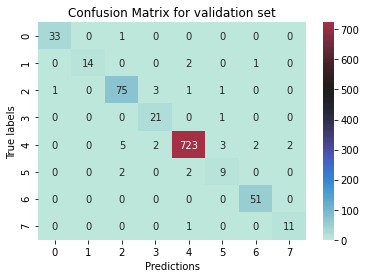

In [33]:
CR = classification_report(y_val, val_predictions)

print(CR)

CM = confusion_matrix(y_val, val_predictions)

plt.figure("Confusion Matrix for validation set")
plt.title("Confusion Matrix for validation set")
sns.heatmap(CM, annot = True, fmt="d", center = 500)
plt.xlabel("Predictions")
plt.ylabel("True labels")
print()

Great, we have pretty good results! Even thought our dataset is imbalanced we have managed to classify correctly most of the examples. Also, we can notice that our algorithm has more difficulties classifying "flight time class" (5), but this is expected since we have just a few examples.

In [34]:
print(encoder.classes_)

['atis_abbreviation' 'atis_aircraft' 'atis_airfare' 'atis_airline'
 'atis_flight' 'atis_flight_time' 'atis_ground_service' 'atis_quantity']


To finalize, let's see one of the most interesting features of an attention model. In contrast to what happens with many deep learning models, in which, we can barely understand how decisions are made by the neural network, attention models provide a more satisfying answer. The latter is possible because of the interpretation of the $\alpha$ coefficients, which essentially, are telling us what part of the text is the most relevant to pick one class over the others.

Consider the following example:

In [35]:
idx_example = np.random.randint(X_val.shape[1])

In [36]:
X_val[:,idx_example]

tensor([329974, 239105, 357266,  97705, 269953, 384122, 150037, 154323, 116225,
        360915, 317286, 153003, 219194, 116225,  47798,  26559, 287045,      0,
             0,      0])

In [37]:
X_val_text[idx_example]

' show me the cheapest one way flights from dallas to san francisco leaving dallas after 4 pm'

From the sentence, we can conclude that the query belongs to the class:

In [38]:
print(encoder.inverse_transform(y_val[idx_example:idx_example+1]))

['atis_flight']


And the algorithm has classified it as:

In [39]:
print(encoder.inverse_transform(val_predictions[idx_example:idx_example+1]))

['atis_flight']


Finally, let's see what words are the ones our algorithm considers to be the most relevant to classify this text: 

In [40]:
print("Alpha vector:")
print( )
print(val_alphas[idx_example,0,:])

Alpha vector:

[5.6713628e-08 2.1137059e-09 4.9550908e-07 3.9594556e-04 2.0063822e-05
 4.2141010e-06 8.5256821e-01 7.3099486e-04 9.1588899e-02 4.7058793e-06
 3.9108671e-02 7.3664980e-03 7.3861134e-05 7.4467626e-03 4.1415138e-04
 1.2950441e-04 1.1184546e-04 1.5096407e-06 2.9568184e-06 3.0603773e-05]


In [41]:
indexes_alpha = np.argsort(val_alphas[idx_example,0,:])[-3:]

In [42]:
print(indexes_alpha)

[10  8  6]


In [43]:
for idx in reversed(indexes_alpha):

  try:
    print("Index value:", idx, ',',  "Value of alpha_index:", val_alphas[idx_example,0,idx], ',', "Word:", X_val_text[idx_example].split()[idx])
    print( )
  except IndexError:
    print("The sentence is not that long")
    print( )

Index value: 6 , Value of alpha_index: 0.8525682 , Word: flights

Index value: 8 , Value of alpha_index: 0.0915889 , Word: dallas

Index value: 10 , Value of alpha_index: 0.03910867 , Word: san

